In [1]:
%load_ext autoreload
%autoreload 2

import galsim
import numpy as np
import ngmix
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook
sns.set()

## Try the Piff PSFs

In [2]:
import piff

SCALE = 0.25

In [3]:
psf = piff.PSF.read("piffs/D00240560_r_c58_r2362p01_piff.fits")

In [4]:
ng = 5

gs = 160 / ng
dg = (gs - 1)/2
objs = []
robjs = []
cen = (160 - 1) / 2
g2s = []
g1s = []
fwhms = []
first_psf = None
for i in range(ng):
    for j in range(ng):
        row = i * gs + dg
        col = j * gs + dg
        image = galsim.ImageD(ncol=17, nrow=17, wcs=galsim.PixelScale(SCALE))
        _psf_im = psf.draw(x=int(col+0.5), y=int(row+0.5), image=image)
        _psf = galsim.InterpolatedImage(_psf_im, wcs=galsim.PixelScale(SCALE))
        if first_psf is None:
            first_psf = _psf
        moms = galsim.hsm.FindAdaptiveMom(_psf_im)
        g1s.append(moms.observed_shape.g1)
        g2s.append(moms.observed_shape.g2)
        fwhms.append(_psf_im.calculateFWHM())
        objs.append(galsim.Convolve(galsim.Gaussian(fwhm=0.0001).shift(
            (col-cen) * SCALE, (row-cen) * SCALE), _psf))
        robjs.append(galsim.Convolve(galsim.Gaussian(fwhm=0.0001).shift(
            (col-cen) * SCALE, (row-cen) * SCALE), first_psf))
        
g1s = np.array(g1s).reshape(ng, ng)
g2s = np.array(g2s).reshape(ng, ng)
fwhms = np.array(fwhms).reshape(ng, ng)

xt = ["%0.1f" % (i * gs + dg) for i in range(ng)]

In [5]:
im = galsim.Sum(objs).drawImage(nx=160, ny=160, scale=SCALE, method='no_pixel').array
rim = galsim.Sum(robjs).drawImage(nx=160, ny=160, scale=SCALE, method='no_pixel').array

Text(0.5, 1.0, 'PSF G2')

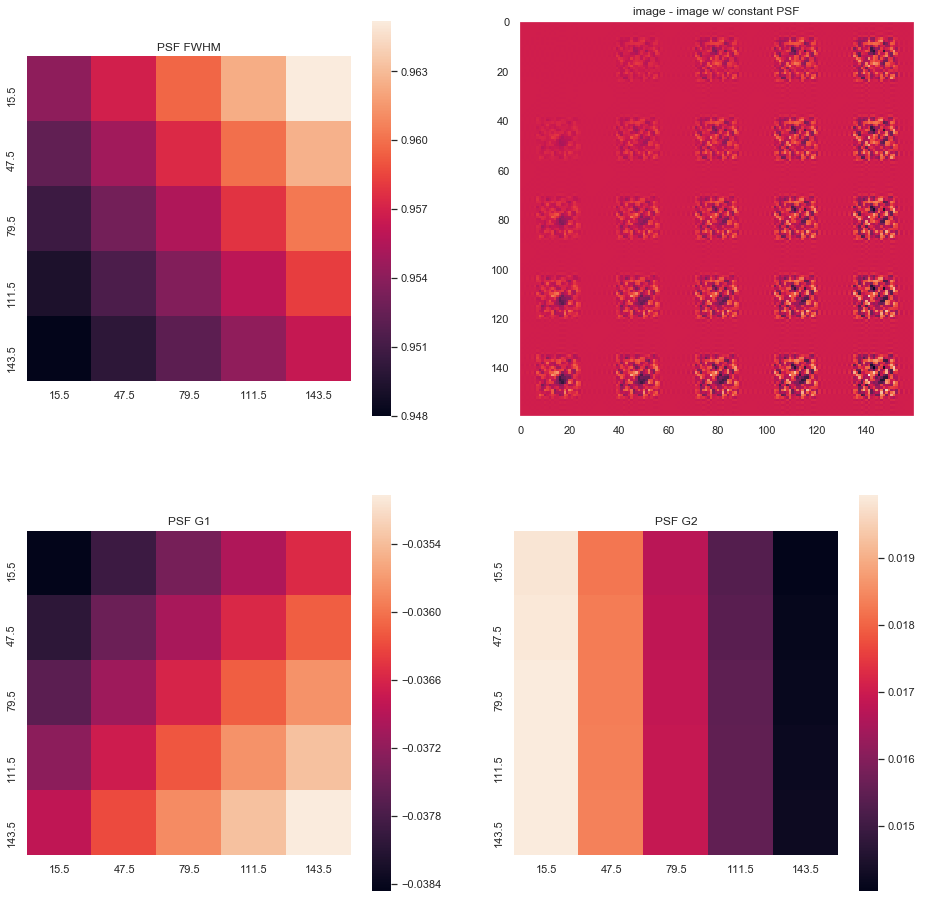

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

ax = axs[0, 0]
sns.heatmap(fwhms, ax=ax, square=True, xticklabels=xt, yticklabels=xt)
ax.set_title('PSF FWHM')

ax = axs[0, 1]
ax.imshow(im - rim)
ax.grid(False)
ax.set_title('image - image w/ constant PSF')

ax = axs[1, 0]
sns.heatmap(g1s, ax=ax, square=True, xticklabels=xt, yticklabels=xt)
ax.set_title('PSF G1')

ax = axs[1, 1]
sns.heatmap(g2s, ax=ax, square=True, xticklabels=xt, yticklabels=xt)
ax.set_title('PSF G2')

In [7]:
def psf_model(row, col):
    image = galsim.ImageD(ncol=17, nrow=17, wcs=galsim.PixelScale(SCALE))
    _psf_im = psf.draw(x=int(col+0.5), y=int(row+0.5), image=image)
    return _psf_im.array

In [96]:
from psf_homogenizer_galsim import PSFHomogenizer

n_kern = 17
hpsf = PSFHomogenizer(psf_model, (160, 160), sigma=1e-6, patch_size=5)

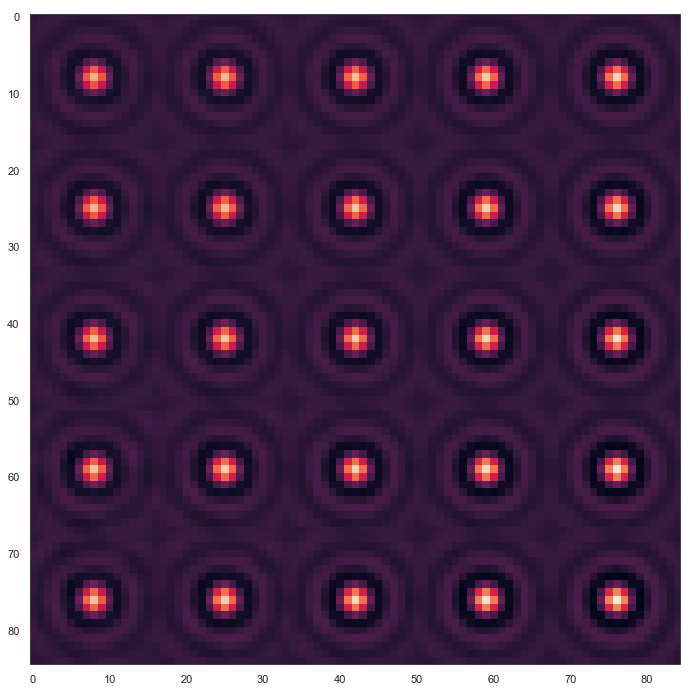

In [97]:
# plot the kernels
gsi = int(gs)
kern = np.zeros((n_kern * ng, n_kern * ng))
for i in range(ng):
    for j in range(ng):
        _is = i * gsi
        _js = j * gsi
        prof = hpsf.get_kernel(_is, _js, sampling_factor=2)
        kern[
            i*n_kern:i*n_kern+n_kern, 
            j*n_kern:j*n_kern+n_kern] = prof        

plt.figure(figsize=(12, 12))
plt.imshow(kern)
plt.gca().grid(False)

In [98]:
%%time

imh = hpsf.homogenize_image(im)

CPU times: user 12.1 s, sys: 127 ms, total: 12.3 s
Wall time: 13.2 s


In [99]:
# make a residual image as if the middle was the correct profile
gsi = int(gs)
_is = ((ng - 1)//2) * gsi
_js = _is
prof = imh[_is:_is+gsi, _js:_js+gsi]
imh_true = np.zeros_like(imh)
for i in range(ng):
    for j in range(ng):
        _is = i * gsi
        _js = j * gsi
        imh_true[_is:_is+gsi, _js:_js+gsi] = prof
        
gsi = int(gs)
_is = ((ng - 1)//2) * gsi
_js = _is
prof = im[_is:_is+gsi, _js:_js+gsi]
im_true = np.zeros_like(imh)
for i in range(ng):
    for j in range(ng):
        _is = i * gsi
        _js = j * gsi
        im_true[_is:_is+gsi, _js:_js+gsi] = prof

Text(0.5, 1.0, 'image')

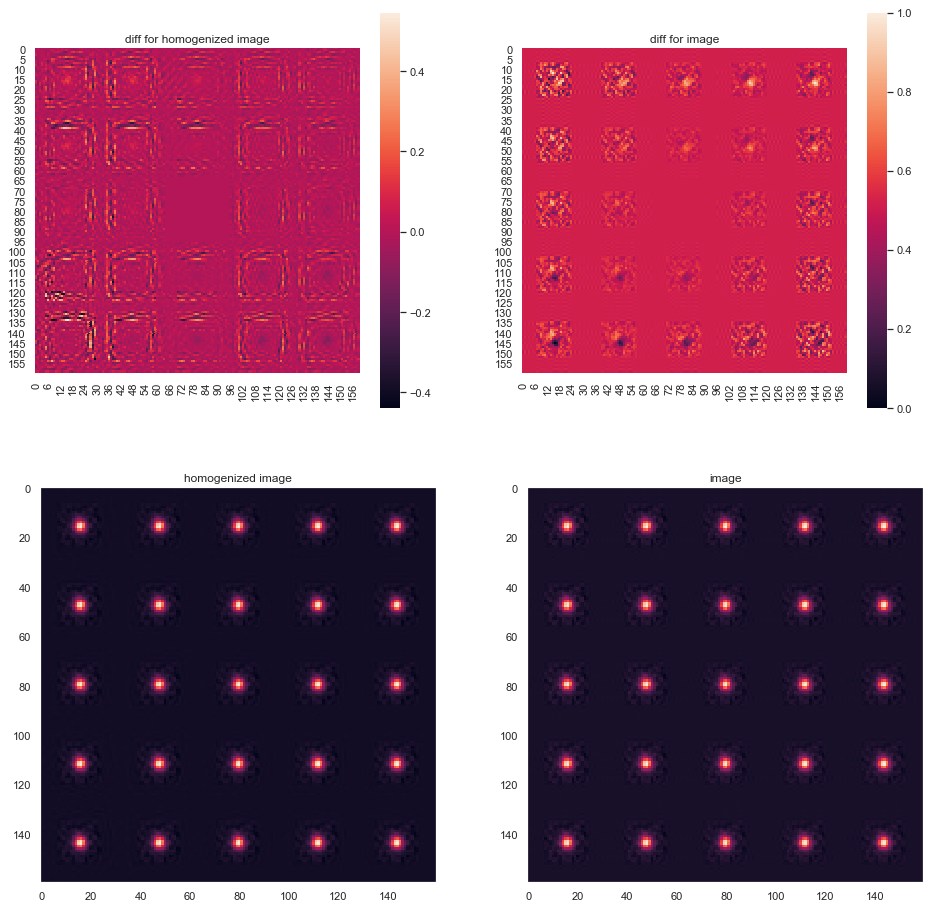

In [100]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

vmin = np.min((im - im_true))
vmax = np.max((im - im_true))

pq = (im - im_true)
pq = (pq - vmin)/(vmax - vmin)

pqh = (imh - imh_true)
pqh = (pqh)/(vmax - vmin)
# pqh -= np.min(pqh)

ax = axs[0, 0]
sns.heatmap(pqh, ax=ax, square=True)
ax.set_title('diff for homogenized image')

ax = axs[0, 1]
sns.heatmap(pq, ax=ax, square=True, vmin=0, vmax=1)
ax.set_title('diff for image')

ax = axs[1, 0]
ax.imshow(imh)
ax.grid(False)
ax.set_title('homogenized image')

ax = axs[1, 1]
ax.imshow(im)
ax.grid(False)
ax.set_title('image')

In [101]:
def _plot_fwhm_g1_g2(imh, ng=5):
    size = imh.shape[0]
    gs = size // ng
    dg = (gs - 1)/2
    hg2s = []
    hg1s = []
    hfwhms = []
    for i in range(ng):
        for j in range(ng):
            img = galsim.ImageD(imh[i*gs:i*gs+gs, j*gs:j*gs+gs], scale=SCALE)
            moms = galsim.hsm.FindAdaptiveMom(img)
            hg1s.append(moms.observed_shape.g1)
            hg2s.append(moms.observed_shape.g2)
            hfwhms.append(img.calculateFWHM())

    hg1s = np.array(hg1s).reshape(ng, ng)
    hg2s = np.array(hg2s).reshape(ng, ng)
    hfwhms = np.array(hfwhms).reshape(ng, ng)

    xt = ["%0.1f" % (i * gs + dg) for i in range(ng)]

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

    ax = axs[0, 0]
    sns.heatmap(hfwhms, ax=ax, square=True, xticklabels=xt, yticklabels=xt)
    ax.set_title('PSF FWHM')

    ax = axs[0, 1]
    ax.imshow(imh)
    ax.grid(False)

    ax = axs[1, 0]
    sns.heatmap(hg1s, ax=ax, square=True, xticklabels=xt, yticklabels=xt)
    ax.set_title('PSF G1')

    ax = axs[1, 1]
    sns.heatmap(hg2s, ax=ax, square=True, xticklabels=xt, yticklabels=xt)
    ax.set_title('PSF G2')
    
    return hfwhms, hg1s, hg2s

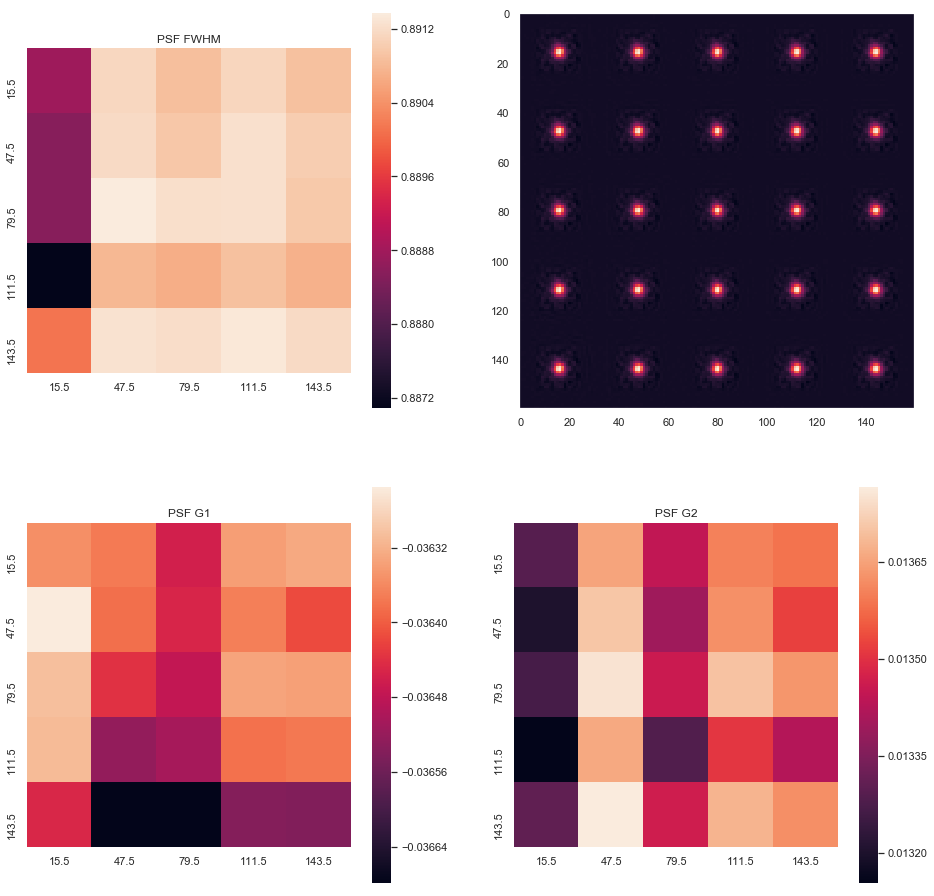

In [102]:
hfwhms, hg1s, hg2s = _plot_fwhm_g1_g2(imh, ng=5)

In [103]:
print(np.max(fwhms)/np.min(fwhms), np.max(hfwhms)/np.min(hfwhms))
print(np.max(g1s) - np.min(g1s), np.max(hg1s) - np.min(hg1s))
print(np.max(g2s) - np.min(g2s), np.max(hg2s) - np.min(hg2s))

1.018158449541035 1.0048240354833322
0.003486923715999138 0.00042307369920725757
0.005897347473711257 0.0006099376963504839


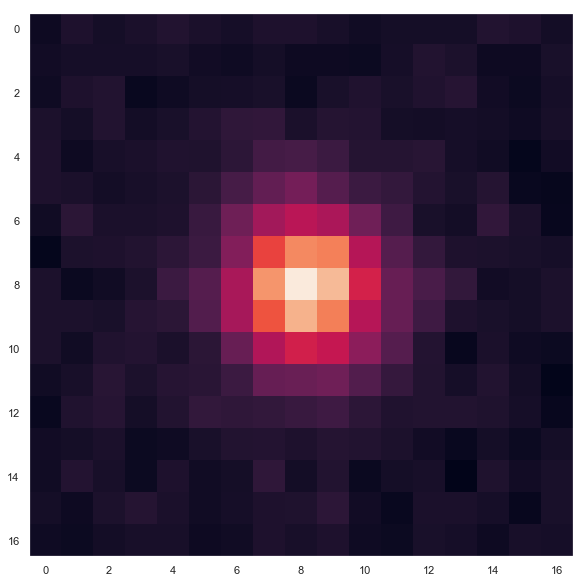

In [95]:
plt.figure(figsize=(10, 10))
plt.imshow(hpsf.get_target_psf())
plt.gca().grid(False)

In [28]:
def psf_model_galsim(row, col):
    image = galsim.ImageD(ncol=17, nrow=17, wcs=galsim.PixelScale(SCALE))
    _psf_im = psf.draw(x=int(col+0.5), y=int(row+0.5), image=image)
    return galsim.InterpolatedImage(_psf_im, wcs=galsim.PixelScale(1.0))

In [29]:
import tqdm

def homogenize_galsim(image, target_psf, psf_model_galsim, sigma=0.1, patch_size=17):
    tgt = galsim.Convolve(target_psf, galsim.Gaussian(sigma=sigma))
    patch_size_2 = (patch_size - 1) // 2
    nrows, ncols = image.shape
    himage = np.zeros_like(image)
    pimage = np.pad(image, patch_size_2, 'constant')
    with tqdm.tqdm(range(nrows)) as itrr:
        for row in itrr:  
            for col in range(ncols):
                patch = galsim.InterpolatedImage(
                    galsim.ImageD(pimage[row:row+patch_size, col:col+patch_size].copy()),
                    wcs=galsim.PixelScale(1.0))

                kern = galsim.Convolve(tgt, galsim.Deconvolve(psf_model_galsim(row, col)))
                hpatch = galsim.Convolve(patch, kern).drawImage(
                    nx=patch_size, ny=patch_size, wcs=galsim.PixelScale(1), method='no_pixel')
                himage[row, col] = hpatch.array[patch_size_2, patch_size_2]
    return himage

In [30]:
target_psf = psf_model_galsim(0, 0)
im = galsim.Sum(objs).drawImage(nx=160, ny=160, scale=SCALE, method='no_pixel').array
him = homogenize_galsim(im, target_psf, psf_model_galsim)

100%|██████████| 160/160 [05:27<00:00,  1.77s/it]


(array([[0.89440525, 0.89528458, 0.89594286, 0.89571086, 0.89545214],
        [0.89503711, 0.89583458, 0.89640585, 0.89614297, 0.89630118],
        [0.89496884, 0.89590583, 0.89605317, 0.89662456, 0.89685239],
        [0.89571596, 0.89632198, 0.89640255, 0.89698081, 0.89726382],
        [0.89647283, 0.89689962, 0.89669155, 0.89700817, 0.89898151]]),
 array([[-0.03877284, -0.03877768, -0.03882061, -0.03833678, -0.03867862],
        [-0.03885456, -0.038837  , -0.03889106, -0.03853773, -0.03911482],
        [-0.03891877, -0.03893707, -0.03892888, -0.03868132, -0.03885379],
        [-0.03909529, -0.03903235, -0.0389627 , -0.03880093, -0.03892132],
        [-0.03911651, -0.03913165, -0.03903284, -0.03890138, -0.03874387]]),
 array([[0.02081668, 0.02087031, 0.02086981, 0.02081964, 0.02071681],
        [0.02085403, 0.02088716, 0.0209693 , 0.02085365, 0.02028153],
        [0.02093285, 0.02094161, 0.02097494, 0.02098041, 0.02090528],
        [0.02093951, 0.02098523, 0.02097802, 0.02099983, 0.02

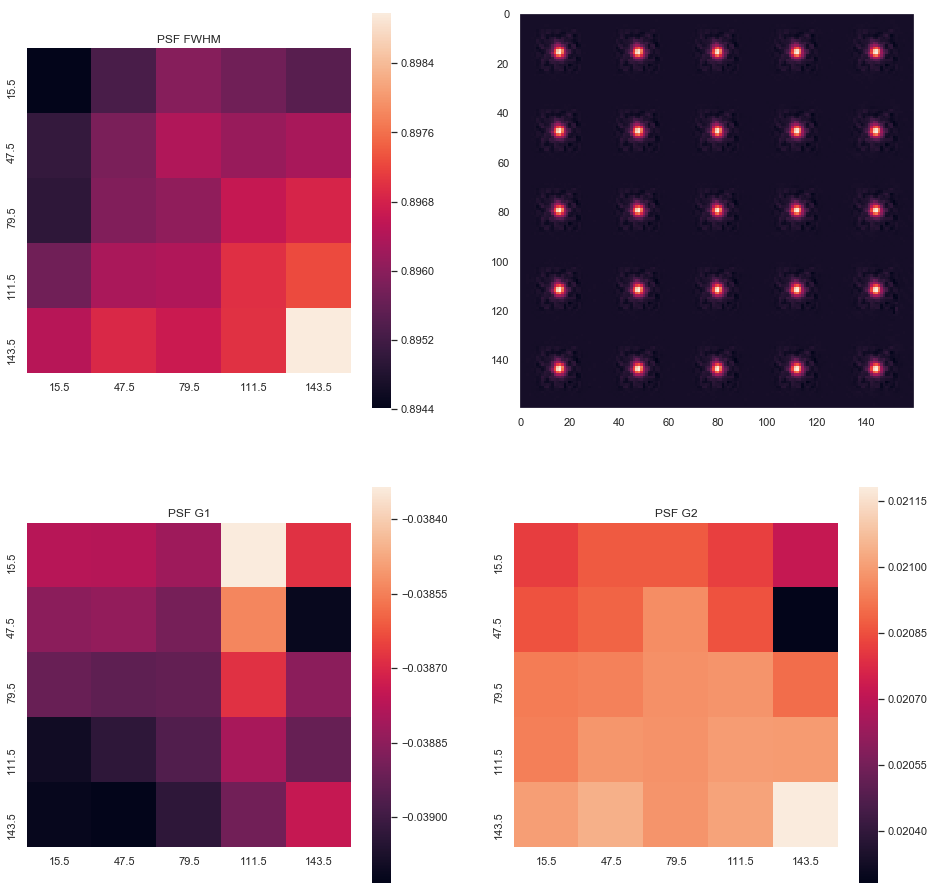

In [31]:
_plot_fwhm_g1_g2(him)

In [47]:
def _plot_hres(im, imh, ng=5):
    gs = im.shape[0] // ng

    # make a residual image as if the middle was the correct profile
    gsi = int(gs)
    _is = ((ng - 1)//2) * gsi
    _js = _is
    prof = imh[_is:_is+gsi, _js:_js+gsi]
    imh_true = np.zeros_like(imh)
    for i in range(ng):
        for j in range(ng):
            _is = i * gsi
            _js = j * gsi
            imh_true[_is:_is+gsi, _js:_js+gsi] = prof

    gsi = int(gs)
    _is = ((ng - 1)//2) * gsi
    _js = _is
    prof = im[_is:_is+gsi, _js:_js+gsi]
    im_true = np.zeros_like(imh)
    for i in range(ng):
        for j in range(ng):
            _is = i * gsi
            _js = j * gsi
            im_true[_is:_is+gsi, _js:_js+gsi] = prof

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

    vmin = np.min((im - im_true))
    vmax = np.max((im - im_true))

    pq = (im - im_true)
    pq = (pq)/(vmax - vmin)

    pqh = (imh - imh_true)
    pqh = (pqh)/(vmax - vmin)
    print(np.median(pqh.ravel()))

    ax = axs[0, 0]
    sns.heatmap(pqh, ax=ax, square=True, vmin=-0.5, vmax=0.5)
    ax.set_title('diff for homogenized image')

    ax = axs[0, 1]
    sns.heatmap(pq, ax=ax, square=True, vmin=0, vmax=1)
    ax.set_title('diff for image')

    ax = axs[1, 0]
    sns.distplot(pqh.ravel(), ax=ax, label='homogenized')
    sns.distplot(pq.ravel(), ax=ax, label='orig')
    ax.set_xlim((-0.5, 0.5))
    ax.legend()

0.0


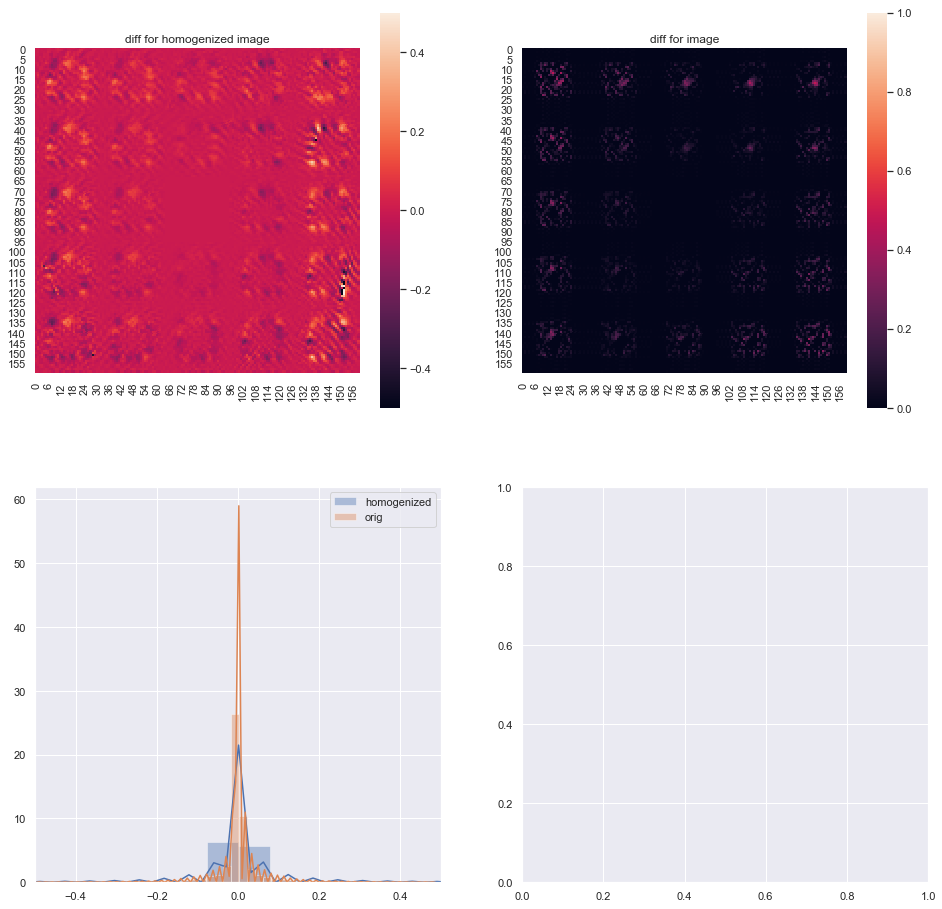

In [48]:
_plot_hres(im, him)